In [1]:
from glob import glob
import numpy as np
from scipy.sparse import load_npz,vstack,save_npz,csr_matrix

In [2]:
txt = []
usr = []

with open("../input/githubrecsys1/repos.txt") as f:
    txt = [x.strip() for x in f.readlines()]
with open("../input/githubrecsys1/users.txt") as f:
    usr = [x.strip() for x in f.readlines()]
    
txt_ind = np.zeros(len(txt),dtype = bool)
usr_ind = np.zeros(len(usr),dtype = bool)

hash_map = {}
for i in range(len(usr)):
    hash_map[usr[i]] = i

src_c = []
txt_c = []
txt_f = []
src_f = []

for i in glob("../input/segmenteddataretrieval1/*"):
    if "count_source" in i:
        src_c.append(i)
    elif "count_text" in i:
        txt_c.append(i)
    elif "TextFeature" in i:
        txt_f.append(i)
    elif "SourceFeature" in i:
        src_f.append(i)
        
for i in txt_c:
    temp = i.split('.')[-2].split('_')
    for i in range(int(temp[-2]),int(temp[-1])+1):
        assert(txt_ind[i] == False),"Intervals Should not overlap"
        txt_ind[i] = True
        usr_ind[hash_map[txt[i].split('/')[0]]] = True

In [3]:
src_c = sorted([(int(x.split('.')[-2].split("_")[-2]),x) for x in src_c])
txt_c = sorted([(int(x.split('.')[-2].split("_")[-2]),x) for x in txt_c])
txt_f = sorted([(int(x.split('.')[-2].split("_")[-2]),x) for x in txt_f])
src_f = sorted([(int(x.split('.')[-2].split("_")[-2]),x) for x in src_f])

In [4]:
count_source = []
count_text = []
feature_source = []
feature_text = []

for i,j in src_c:
    count_source.append(load_npz(j))
for i,j in txt_c:
    count_text.append(load_npz(j))
for i,j in src_f:
    feature_source.append(load_npz(j))
for i,j in txt_f:
    feature_text.append(load_npz(j))

In [5]:
count_source = vstack(count_source)
count_text = vstack(count_text)
feature_source = vstack(feature_source)
feature_text = vstack(feature_text)

try:
    assert( count_source.shape == count_text.shape == feature_source.shape == feature_text.shape)
except:
    print("count_source_shape:",count_source.shape)
    print("count_text_shape:",count_text.shape)
    print("feature_source_shape:",feature_source.shape)
    print("feature_text_shape:",feature_text.shape)
else:
    print(count_source.shape)

(5945, 10007)


In [6]:
idf_source = np.log(count_source.shape[0] / (count_source.sum(axis = 0) + 1))
idf_text = np.log(count_text.shape[0] / (count_text.sum(axis = 0) + 1))
tfidf_text = feature_text.multiply(idf_text)
tfidf_source = feature_source.multiply(idf_source)

In [7]:
np.save("valid_repos",txt_ind)
np.save("valid_users",usr_ind)
np.save("idf_source",idf_source)
np.save("idf_text",idf_text)
save_npz("tfidf_text",tfidf_text)
save_npz("tfidf_source",tfidf_source)

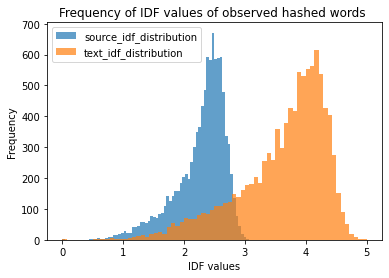

In [8]:
import matplotlib.pyplot as plt
_ = plt.hist(np.array(idf_source)[0],bins = 70,alpha = 0.7)
_ = plt.hist(np.array(idf_text)[0],bins = 70,alpha = 0.7)
plt.legend(["source_idf_distribution","text_idf_distribution"])
_ = plt.xlabel("IDF values")
_ = plt.ylabel("Frequency")
_ = plt.title("Frequency of IDF values of observed hashed words ")

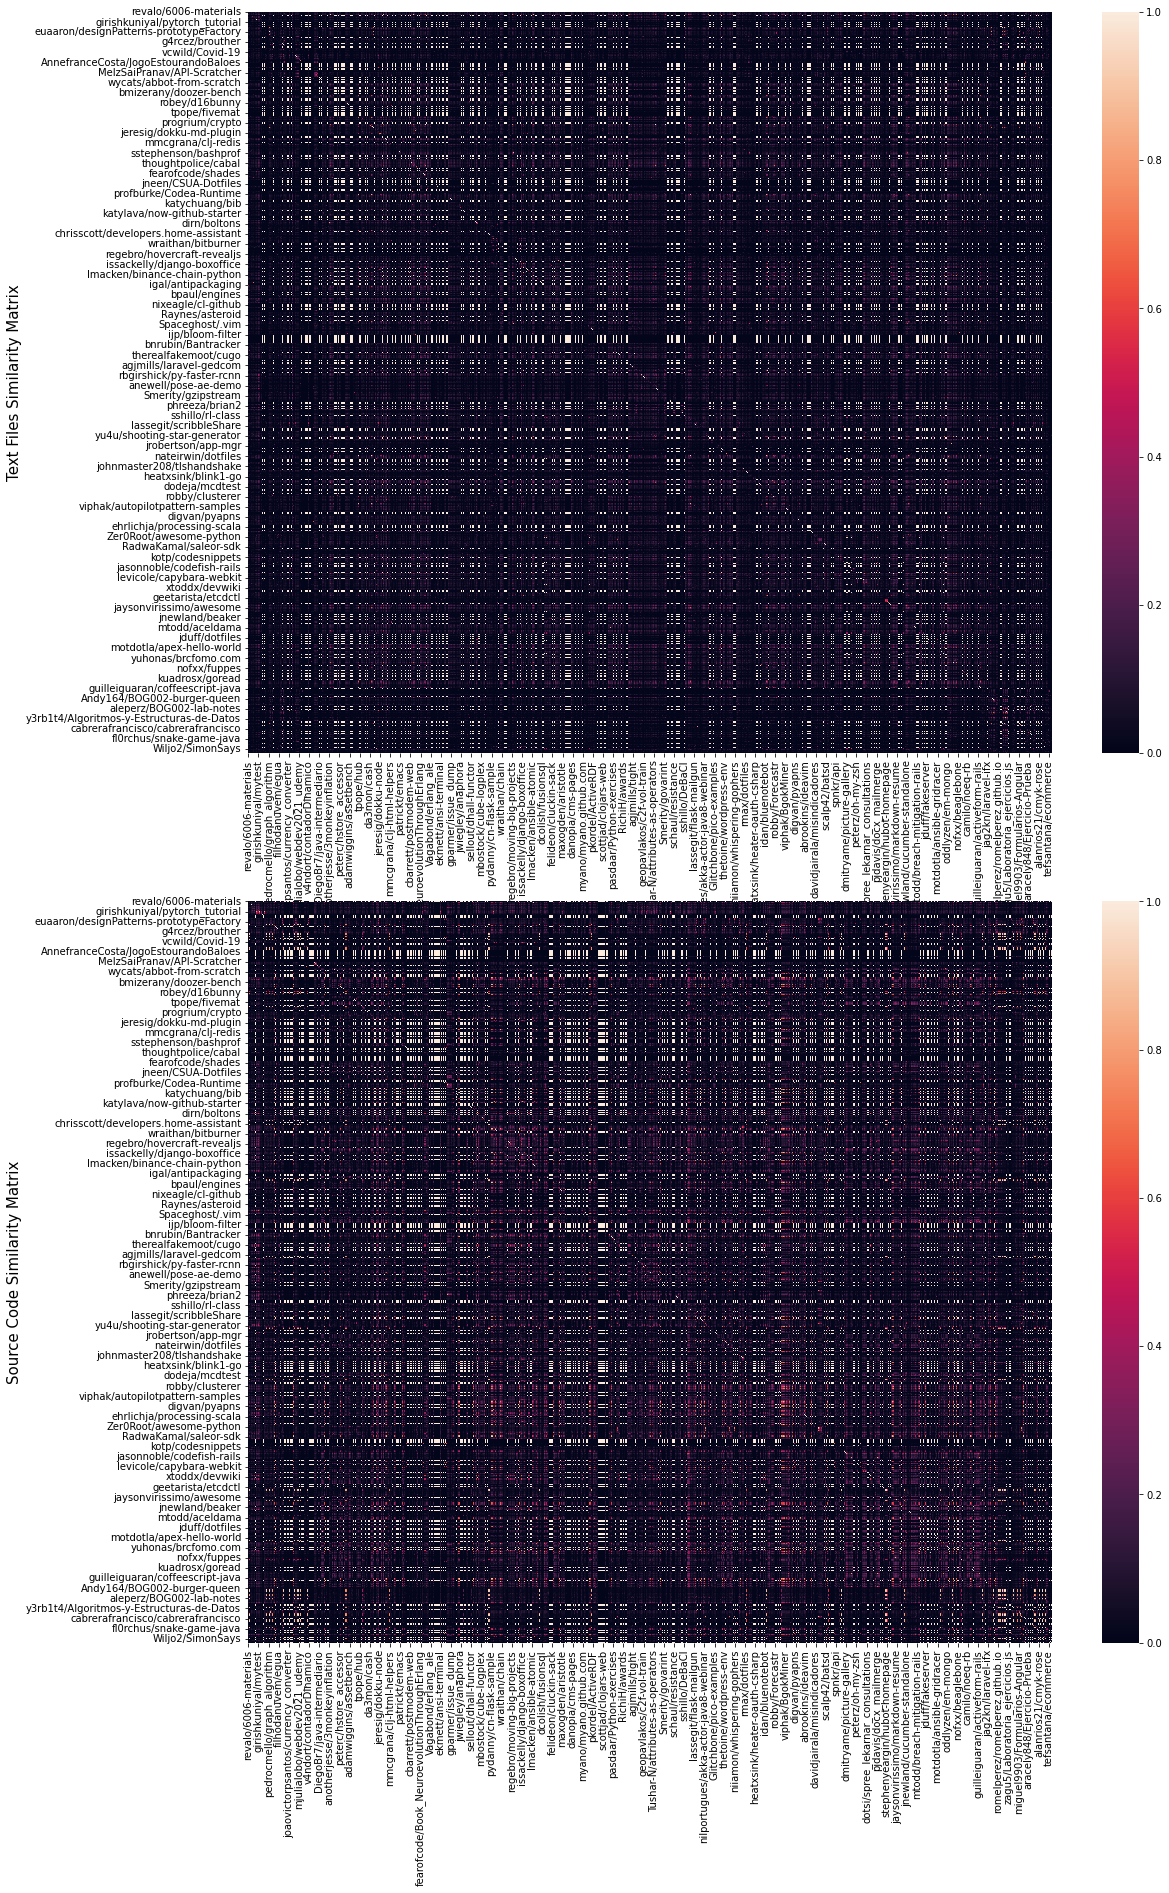

In [9]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
out = []
for i in np.where(txt_ind)[0]:
    out.append(txt[i])
Repo_similarity_text = cosine_similarity(tfidf_text,tfidf_text)
Repo_similarity_source = cosine_similarity(tfidf_source,tfidf_source)
Repo_similarity_text = pd.DataFrame(Repo_similarity_text,columns = out,index = out)
Repo_similarity_source = pd.DataFrame(Repo_similarity_source,columns = out,index = out)
Repo_similarity_text = Repo_similarity_text.iloc[0:,0:]
Repo_similarity_source = Repo_similarity_source.iloc[0:,0:]
fig = plt.figure(figsize = (18,30))
plt.subplot(211)
sns.heatmap(Repo_similarity_text)
plt.ylabel("Text Files Similarity Matrix",fontsize = 15)
plt.subplot(212)
sns.heatmap(Repo_similarity_source)
plt.ylabel("Source Code Similarity Matrix",fontsize = 15)
plt.savefig("sample_similarity_matrix")